In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True

MIN_CAUSAL_SCORE = 0.3


############ Load data #############
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
dnaseI = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])

# All ref data
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# TF ref data
ref_tf = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_tfbs.bed"), sep="\t")
ref_tf["str.start"] = ref_tf["start"]
ref_tf = pd.merge(ref_tf, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# Gene annot
geneannot = pd.read_csv(GENEANNOT)

# CAVIAR table
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene","gene.strand"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)

Populating the interactive namespace from numpy and matplotlib


In [6]:
default_bins = np.arange(-50000, 50000, 1000)

CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def ProcessData(all_str_genes, estrs, causal, col, bins=default_bins, useabs=False):
    #keys = ["ALL","AC","GT","CG","AT","AG","CT","A","T"]
    all_motifs = set(all_str_genes["motif"])
    othermotifs = {
        "AC": ["AC"],
        "GT": ["GT"],
        "AG": ["AG"],
        "CT": ["CT"],
        "CG": ["CG","CCG","CCCG","CCCCG","CCCCCG","CCCCGG"],
        "GC": ["CG", "CGG", "CGGG", "CGGGG", "CGGGGG", "CCGGGG"],
        "AT": ["AT"],
        "AG": ["AG"],
        "AGG": ["AGG"],
        "A": ["A"],
        "T": ["T"],
        "2": [item for item in all_motifs if len(item)==2],
        "1": [item for item in all_motifs if len(item)==1],
        "5": [item for item in all_motifs if len(item)==5],
        "6": [item for item in all_motifs if len(item)==6],
        "4": [item for item in all_motifs if len(item)==4],
        "3": [item for item in all_motifs if len(item)==3],
        "ALL": all_motifs
    }
    keys = othermotifs.keys()
    num = {}
    p = {}
    p_causal = {}
    
    num_total = all_str_genes[["chrom","str.start"]].drop_duplicates().shape[0]
    num_estrs = estrs[["chrom","str.start"]].drop_duplicates().shape[0]
    num_causal = causal[["chrom","str.start"]].drop_duplicates().shape[0]
    p_avg = num_estrs*1.0/num_total
    p_causal_avg = num_causal*1.0/num_total
    
    # Get bindata
    for key in keys:
        num[key] = []
        p[key] = []
        p_causal[key] = []
        
        all_motif_data = all_str_genes[all_str_genes["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        estr_motif_data = estrs[estrs["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        causal_motif_data = causal[causal["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        
        estr_motif_data = pd.merge(all_motif_data, estr_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        causal_motif_data = pd.merge(all_motif_data, causal_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        
        for i in range(len(bins)-1):
            lb = bins[i]
            ub = bins[i+1]
            if not useabs:
                x_all = all_motif_data[(all_motif_data[col]>=lb) & (all_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_estr = estr_motif_data[(estr_motif_data[col]>=lb) & (estr_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_causal = causal_motif_data[(causal_motif_data[col]>=lb) & (causal_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            else:
                nlb = abs(lb)
                nub = abs(ub)
                if nub<nlb:
                    nlb = abs(ub)
                    nub = abs(lb)
                x_all = all_motif_data[(all_motif_data[col].apply(abs)>=nlb) & (all_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_estr = estr_motif_data[(estr_motif_data[col].apply(abs)>=nlb) & (estr_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_causal = causal_motif_data[(causal_motif_data[col].apply(abs)>=nlb) & (causal_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                #print("%s %s %s"%(x_all, nlb, nub))
            if x_all == 0:
                num[key].append(0)
                p[key].append(float("nan"))
                p_causal[key].append(float("nan"))
            else:
                num[key].append(x_all*1.0/all_motif_data.shape[0])
                p[key].append(x_estr*1.0/x_all)
                p_causal[key].append(x_causal*1.0/x_all)
    return num, p, p_causal, p_avg, p_causal_avg

def Smooth(x, buf=2, avg=None, norm=False):
    if avg is not None:
        x = [item*1.0/avg for item in x]
    if norm:
        m = np.mean(x)
        x = [item*1.0/m for item in x]
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

def PlotPosition(num, p, p_causal, p_avg, pcausal_avg, bins=default_bins, buf=2, col=None, RESULTSDIR=None):
    colors = {
    "ALL": ("black", "solid"),
    "A": ("gray", "solid"),
    "T": ("gray", "dashed"),
    "AC": ("red", "solid"),
        "GT": ("red", "dashed"),
        "AT": ("maroon", "solid"),
        "1": ("gray", "solid"),
        "2": ("red", "solid"),
        "3": ("gold", "solid"),
        "4": ("blue", "solid"),
        "5": ("green", "solid"),
        "6": ("purple", "solid"),
        "CG": ("darkgreen", "solid"),
        "GC": ("darkgreen", "dashed")
    }
    size = ((10, 4))
    usekeys = colors.keys()
    
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    keys = ["1","2","4","3","5","6", "ALL"]
    for key in keys:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
    ax.set_ylabel("Relative abundance", size=12)
    ax.legend(loc="lower left")
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_num.pdf"%col))
    
    # For supplement, plot strand diffs
    for mp in [("AC","GT"), ("A","T"), ("CG","GC")]:
        fig = plt.figure()
        fig.set_size_inches(size)
        ax2 = fig.add_subplot(111)
        for key in mp:
            ax2.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
            ax2.set_ylabel("Relative abundance", size=12)
        ax2.legend(loc="lower left")
        if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_%s_num_%s.pdf"%(col, mp[0])))

    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    for key in ["ALL"]:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(p[key], avg=p_avg, buf=buf)), color=ESTR_COLOR, linewidth=w, label=key)
        ax.plot(bins[:-1], (Smooth(p_causal[key], avg=p_causal_avg, buf=buf)), color=CAUSAL_COLOR, linewidth=w, label=key)
    ax.set_ylabel("P(eSTR)", size=12)
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_peSTR.pdf"%col))
        


In [3]:
# TSS Localization
geneannot["gene"] = geneannot["gene.id"]
HIPREF="/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed"
hipref = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","period","str.motif.forward","str.motif.reverse"])

all_str_genes = pd.merge(allstrs, geneannot[["gene","gene.start","gene.stop","gene.strand"]], on=["gene"])
all_str_genes["gene"] = all_str_genes["gene"].apply(lambda x: x.split(".")[0])
all_str_genes = pd.merge(all_str_genes, hipref[["chrom","str.start","str.motif.forward","str.motif.reverse"]], on=["chrom","str.start"])
all_str_genes["motif"] = all_str_genes.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
all_str_genes["dist.tss"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["dist.tes"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="-" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes = pd.merge(all_str_genes, dnaseI[["chrom","str.start","dist.dnase"]], on=["chrom","str.start"])

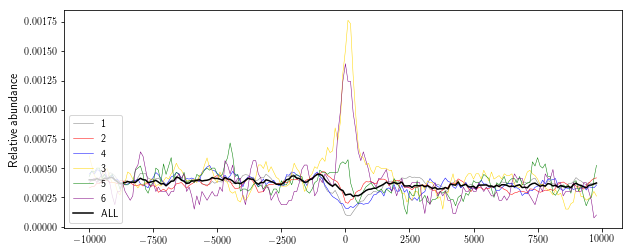

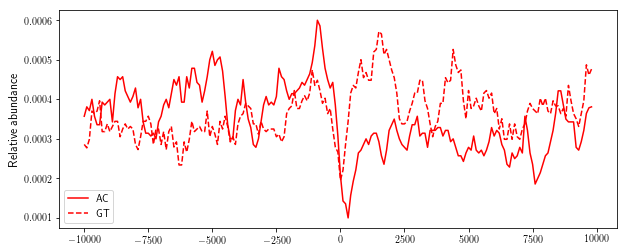

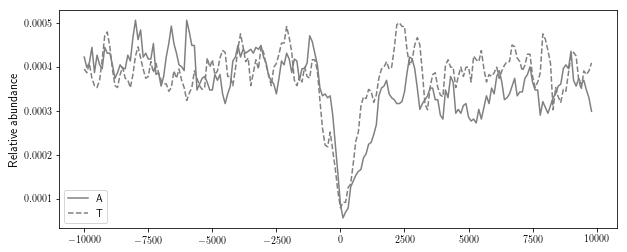

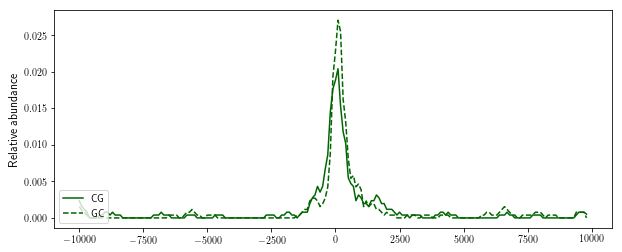

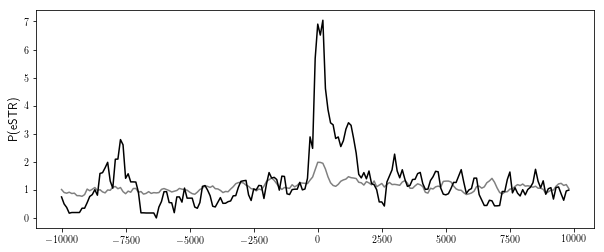

In [7]:
bins = np.arange(-10000, 10000, 100)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, estrs[estrs["score"]>=MIN_CAUSAL_SCORE], "dist.tss", bins=bins)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.tss", RESULTSDIR=RESULTSDIR)

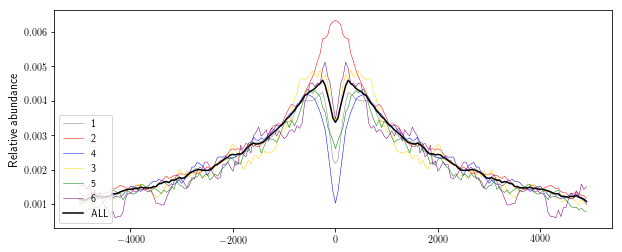

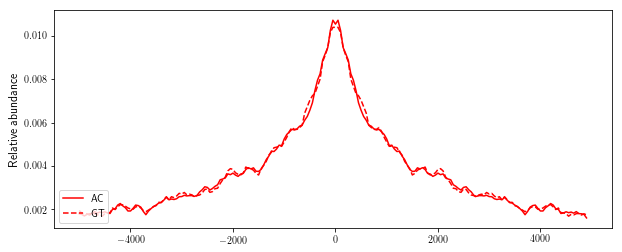

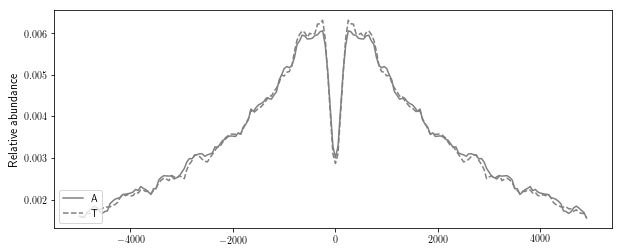

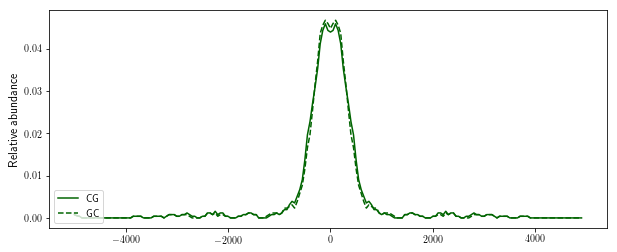

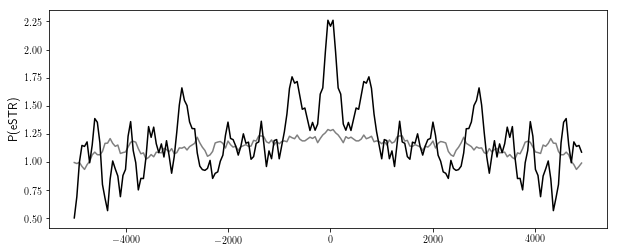

In [8]:
bins = np.arange(-5000, 5000, 50)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, estrs[estrs["score"]>=MIN_CAUSAL_SCORE], "dist.dnase", bins=bins, useabs=True)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.dnase", RESULTSDIR=RESULTSDIR)